# PREP

In [18]:
import os
import numpy as np
import pandas as pd
from functools import reduce
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score
)
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

In [19]:
REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'
RESULTDIR = os.path.join(REPODIR, 'results')
# REPODIR = '/home/wimmerl/projects/wildlife-experiments'

CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
EMPTY_CLASS = LABEL_MAP['empty']
CONFMAT_ARGS = {
    'normalize': 'true',
    'values_format': '.2f',
    'display_labels': list(LABEL_MAP.keys()),
    'xticks_rotation': 'vertical',
    'colorbar': False,
    'cmap': 'Blues',
}

# IN-SAMPLE

In [95]:
# FILES_INSAMPLE = [
#     os.path.join(RESULTDIR, '0', f) for f in os.listdir(os.path.join(RESULTDIR, '0')) if 'insample_val' in f
# ]
# FILES_INSAMPLE = [os.path.join(RESULTDIR, f) for f in os.listdir(RESULTDIR) if 'insample_test' in f]
# RESULTS_INSAMPLE = [load_pickle(f) for f in FILES_INSAMPLE]
# THRESHOLDS = [0, 0.3, 0.5, 0.7, 0.9]
THRESHOLDS = [0.1]

In [96]:
FILES_INSAMPLE = [
    [os.path.join(RESULTDIR, t, f) for f in os.listdir(os.path.join(RESULTDIR, t)) if 'insample_val' in f] 
    for t in [str(int(100 * ts)) for ts in THRESHOLDS]
]

In [113]:
FILES_INSAMPLE

[['/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments/results/10/202303151545_insample_val_123.pkl']]

In [97]:
# custom averaging functions accounting for specific ordering
def average_results(dict_list_preds, list_truth):
    ordered_dicts = [{k: d[k] for k in sorted(list(d.keys()))} for d in dict_list_preds]
    ordered_arrays = [
        np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(d.values())]) for d in ordered_dicts
    ]
    ordered_lists = [
        [x[k] for k in [list(d.keys()).index(i) for i in sorted(list(d.keys()))] ]
        for x, d in zip(list_truth, dict_list_preds)
    ]
    return reduce(np.add, ordered_arrays) / len(dict_list_preds), ordered_lists[0]

In [98]:
results_insample_avg = {}
for idx, t in enumerate(THRESHOLDS):
    results_t = [load_pickle(f) for f in FILES_INSAMPLE[idx]]
#     results_t = [r[t] for r in RESULTS_INSAMPLE]
#     results_t = RESULTS_INSAMPLE
    preds_imgs_clf_t, truth_imgs_clf_t = average_results(
        [r['preds_imgs_clf'] for r in results_t], [r['truth_imgs_clf'] for r in results_t]
    )
    preds_imgs_ppl_t, truth_imgs_ppl_t = average_results(
        [r['preds_imgs_ppl'] for r in results_t], [r['truth_imgs_ppl'] for r in results_t]
    )
    results_insample_avg.update(
        {
            t: {
                'preds_imgs_clf': preds_imgs_clf_t,
                'preds_imgs_ppl': preds_imgs_ppl_t,
                'truth_imgs_clf': truth_imgs_clf_t,
                'truth_imgs_ppl': truth_imgs_ppl_t
                
            }
        }
    )

In [55]:
# RESULTS_INSAMPLE_TEST_01 = load_pickle('results/202303010719_insample_test.pkl')
# RESULTS_INSAMPLE_VAL_01 = load_pickle('results/202303010719_insample_test.pkl')
# RESULTS_INSAMPLE_TEST_05 = load_pickle('results/202302280915_insample_test.pkl')
# RESULTS_INSAMPLE_VAL_05 = load_pickle('results/202302280915_insample_val.pkl')

In [111]:
# RESULT_FILE = {**RESULTS_INSAMPLE_TEST_01, **RESULTS_INSAMPLE_TEST_05}
RESULT_FILE = results_insample_avg
THRESHOLDS = list(RESULT_FILE.keys())
OUR_THRESH = 0.7
PREDS = 'preds_imgs_ppl'
TRUTH = 'truth_imgs_ppl'

In [119]:
len(RESULT_FILE[0.1]['truth_imgs_ppl'])

1265

In [ ]:
RESULT_FILE[0.1][PREDS]

## PERFORMANCE ACROSS THRESHOLDS ON TEST

Using varying thresholds for the MD, how well is our pipeline able to 1) classify images overall, 2) detect empty images correctly?

In [112]:
rows_multiclass = []
rows_empty = []

for t in sorted(THRESHOLDS):
    result = RESULT_FILE[t]
    y_true = result[TRUTH]
    print(len(y_true))
    y_pred = [np.argmax(v) for v in result[PREDS]]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys()),
        zero_division=0,
        output_dict=True,
    )
    print(
        classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
        )
    )
    rows_multiclass.append(
        [
            t,
            report['accuracy'], 
            report['weighted avg']['precision'], 
            report['weighted avg']['recall'], 
            report['weighted avg']['f1-score']
        ]    
    )
    conf_empty = multilabel_confusion_matrix(y_true, y_pred, labels=[EMPTY_CLASS])
    rows_empty.append(
        [
            t,
            (conf_empty[0][0, 0] + conf_empty[0][1, 1]) / conf_empty.sum(),
            report['empty']['precision'],
            report['empty']['recall'],
            report['empty']['f1-score'],
        ]
    )
df_ins_multiclass = pd.DataFrame(rows_multiclass, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])
df_ins_empty = pd.DataFrame(rows_empty, columns=['threshold', 'acc', 'prec', 'rec', 'fone'])

1265
               precision    recall  f1-score   support

        empty       0.89      0.66      0.76       281
european_hare       0.67      0.75      0.71        52
       others       0.36      0.45      0.40        86
     red_deer       1.00      0.33      0.50         3
      red_fox       0.80      0.83      0.81        69
 red_squirrel       0.94      0.87      0.91        39
     roe_deer       0.89      0.97      0.93       698
    wild_boar       0.92      0.59      0.72        37

     accuracy                           0.83      1265
    macro avg       0.81      0.68      0.72      1265
 weighted avg       0.84      0.83      0.83      1265



In [105]:
df_ins_multiclass.sort_values('threshold')  # Table 3

,threshold,acc,prec,rec,fone
0,0.1,0.831621,0.843025,0.831621,0.830836


In [106]:
df_ins_empty.sort_values('threshold')  # Table 2

,threshold,acc,prec,rec,fone
0,0.1,0.906719,0.889952,0.661922,0.759184


## PERFORMANCE

               precision    recall  f1-score   support

        empty       0.89      0.83      0.86       100
european_hare       0.84      0.79      0.82        48
       others       0.61      0.47      0.53        75
     red_deer       1.00      0.33      0.50         3
      red_fox       0.84      0.82      0.83        65
 red_squirrel       0.92      0.94      0.93        35
     roe_deer       0.92      0.97      0.95       684
    wild_boar       0.93      0.74      0.83        35

     accuracy                           0.89      1045
    macro avg       0.87      0.74      0.78      1045
 weighted avg       0.89      0.89      0.89      1045



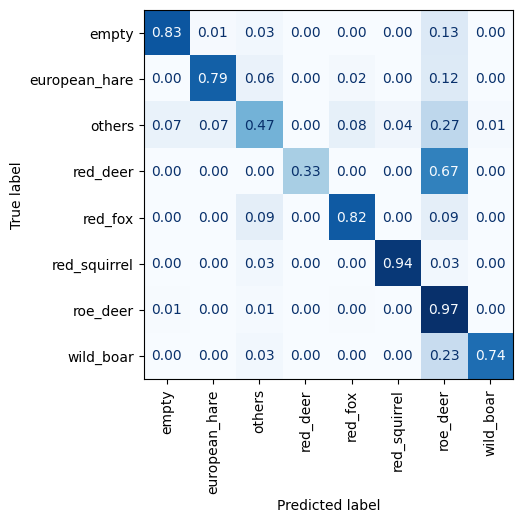

In [79]:
result_ours = results_insample_avg[0.7]
y_true = result_ours['truth_imgs_ppl']
y_pred = [np.argmax(v) for v in result_ours['preds_imgs_ppl']]
report = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(LABEL_MAP.keys())
)
print(report)  # Figure 3
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

# OUT-OF-SAMPLE

## PERFORMANCE

In [80]:
RESULTS_OOSAMPLE = load_pickle('results/202302240832_oosample.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'results/202302240832_oosample.pkl'

In [12]:
y_true = RESULTS_OOSAMPLE['truth_imgs_ppl']
y_pred = [np.argmax(v) for v in RESULTS_OOSAMPLE['preds_imgs_ppl'].values()]
report_dict = classification_report(
    y_true=y_true, 
    y_pred=y_pred,
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
)
rows_oos_multiclass = []
rows_oos_multiclass.append(
    [
        report_dict['accuracy'], 
        report_dict['weighted avg']['precision'], 
        report_dict['weighted avg']['recall'], 
        report_dict['weighted avg']['f1-score']
    ]
)


In [13]:
df_oos_multiclass = pd.DataFrame(
    rows_oos_multiclass,
    columns=['acc', 'prec', 'rec', 'fone']
)
df_multiclass = pd.concat([df_ins_multiclass.loc[df_ins_multiclass['threshold'] == OUR_THRESH], df_oos_multiclass])
df_multiclass.index = ['ins', 'oos']

In [14]:
df_multiclass.drop(['threshold'], axis=1)  # Table 5

,acc,prec,rec,fone
ins,0.877925,0.876128,0.877925,0.874281
oos,0.721370,0.743104,0.721370,0.706258


               precision    recall  f1-score   support

        empty       0.87      0.41      0.56       371
european_hare       0.60      0.52      0.56        29
       others       0.29      0.25      0.27       119
     red_deer       0.50      0.18      0.26        17
      red_fox       0.33      0.56      0.42        18
 red_squirrel       0.05      1.00      0.09         1
     roe_deer       0.75      0.92      0.83      1015
    wild_boar       0.86      0.65      0.74       124

     accuracy                           0.72      1694
    macro avg       0.53      0.56      0.46      1694
 weighted avg       0.74      0.72      0.71      1694



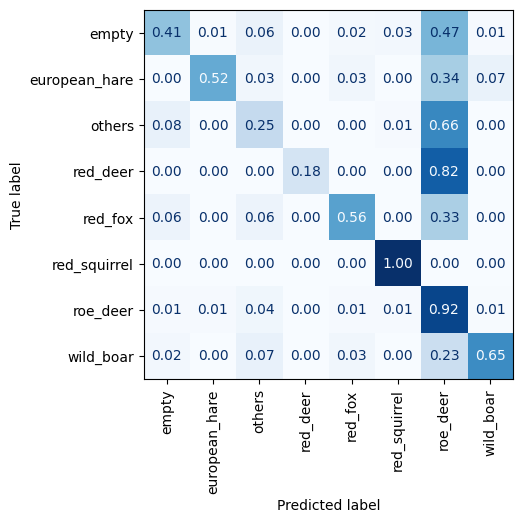

In [15]:
print(  # Figure 5
    classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys())
    )

) 
ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, **CONFMAT_ARGS)

## ACTIVE LEARNING

In [ ]:
RESULTS_ACTIVE_UPPER_BASELINE = load_pickle('results/202302101959_results_active_optimal.pkl')

In [ ]:
print(
    classification_report(
        y_true=RESULTS_ACTIVE_UPPER_BASELINE['truth_imgs_ppl'], 
        y_pred=[np.argmax(v) for v in RESULTS_ACTIVE_UPPER_BASELINE['preds_imgs_ppl'].values()],
        target_names=list(LABEL_MAP.keys())
    )

) 

In [ ]:
# eval_upper_perf_limit = load_pickle(
#     'results/202212011038_results_oosample_active_optimal.json'
# )
# eval_al_coldstart = load_pickle('results/202212041731_eval_logfile_coldstart.json')
# eval_al_warmstart = load_pickle('results/202212080940_eval_logfile_warmstart.json')
# # compute relative sample size per iteration
# # (sizes hard-coded for training)
# n_samples_total = len(load_pickle('data/dataset_oos_trainval.pkl').keys)
# num_max_batches = (
#     (n_samples_total - (5 * 128 + 5 * 256 + 5 * 512)) // 1024
# )
# size_last_batch = (
#     n_samples_total - (5 * 128 + 5 * 256 + 5 * 512 + num_max_batches * 1024)
# )
# batch_sizes = (
#     5 * [128] + 5 * [256] + 5 * [512] + num_max_batches * [1024]
# )
# if size_last_batch > 0:
#     batch_sizes.append(size_last_batch)
# batch_sizes_cs = np.cumsum([x / n_samples_total for x in batch_sizes])
# # inspect upper performance limit
# df_pred_upper_perf_limit = rf.build_df_pred(eval_upper_perf_limit, label_dict, detector_dict, image_data_dir)
# df_pred_upper_perf_limit = rf.labelize_df_pred(df_pred_upper_perf_limit, label_map)
# df_pred_upper_perf_limit = pd.merge(df_pred_upper_perf_limit, df_meta, on=['img_name', 'true_class'], how='inner')
# report_upper_perf_limit = classification_report(
#     y_true=df_pred_upper_perf_limit['true_class'],
#     y_pred=df_pred_upper_perf_limit['pred_class'],
#     labels=labels,
#     zero_division=0,
#     output_dict=False,
# )
# print(report_upper_perf_limit)

# rf.inspect_confusion(
#     df_pred=df_pred_upper_perf_limit,
#     normalize=True,
#     labels=labels,
#     ax=None,
# )
# report_upper_perf_limit_dict = classification_report(
#     y_true=df_pred_upper_perf_limit['true_class'],
#     y_pred=df_pred_upper_perf_limit['pred_class'],
#     labels=labels,
#     zero_division=0,
#     output_dict=True,
# )
# print(report_upper_perf_limit_dict)
# # compute metrics per iteration

# acc_coldstart = []
# rec_coldstart = []
# acc_warmstart = []
# rec_warmstart = []

# for iteration in eval_al_coldstart.keys():
#     df_cs = rf.build_df_pred(eval_al_coldstart[iteration], label_dict, detector_dict, image_data_dir)
#     df_cs = rf.labelize_df_pred(df_cs, label_map)
#     df_cs = pd.merge(df_cs, df_meta, on=['img_name', 'true_class'], how='inner')
#     report_cs = classification_report(
#         y_true=df_cs['true_class'],
#         y_pred=df_cs['pred_class'],
#         labels=labels,
#         zero_division=0,
#         output_dict=True,
#     )
#     df_ws = rf.build_df_pred(eval_al_warmstart[iteration], label_dict, detector_dict, image_data_dir)
#     df_ws = rf.labelize_df_pred(df_ws, label_map)
#     df_ws = pd.merge(df_ws, df_meta, on=['img_name', 'true_class'], how='inner')
#     report_ws = classification_report(
#         y_true=df_ws['true_class'],
#         y_pred=df_ws['pred_class'],
#         labels=labels,
#         zero_division=0,
#         output_dict=True,
#     )
#     acc_coldstart.append(report_cs['accuracy'])
#     rec_coldstart.append(report_cs['weighted avg']['recall'])
#     acc_warmstart.append(report_ws['accuracy'])
#     rec_warmstart.append(report_ws['weighted avg']['recall'])

# # create data for plot
# al_perf_acc = {
#     'relative_size': batch_sizes_cs[1:],
#     'acc_lower_limit': [report_lower_perf_limit_dict['accuracy'] for _ in range(len(acc_coldstart))],
#     'acc_upper_limit': [report_upper_perf_limit_dict['accuracy'] for _ in range(len(acc_coldstart))],
#     'acc_coldstart': acc_coldstart,
#     'acc_warmstart': acc_warmstart
# }
# al_perf_acc_pd = pd.DataFrame(al_perf_acc)
# al_perf_rec = {
#     'relative_size': batch_sizes_cs[1:],
#     'rec_lower_limit': [report_lower_perf_limit_dict['weighted avg']['recall'] for _ in range(len(acc_coldstart))],
#     'rec_upper_limit': [report_upper_perf_limit_dict['weighted avg']['recall'] for _ in range(len(acc_coldstart))],
#     'rec_coldstart': rec_coldstart,
#     'rec_warmstart': rec_warmstart
# }
# al_perf_acc_pd = pd.DataFrame(al_perf_acc)
# al_perf_rec_pd = pd.DataFrame(al_perf_rec)
# plt = sns.lineplot(
#     data=pd.melt(al_perf_acc_pd, id_vars='relative_size'),
#     x='relative_size',
#     y='value',
#     hue='variable',
#     style='variable'
# )
# plt.set(xlabel='relative sample size', ylabel='accuracy')
# plt.legend(
#     title='training mode', 
#     loc='lower right', 
#     labels=['lower baseline', 'upper baseline', 'cold start', 'warm start']
# )
# plt.figure.savefig('oos_active.eps')